## Experimenting with  TFIDF using Perceptron and Multi-layer Perceptron classifiers:

**TF-IDF Representation**: TF-IDF works by determining the relative frequency of words in a specific document compared to the inverse proportion of that word over the entire document corpus. Its used with a vocaburaly size of `51758` to take only words with term frequency of higher than `25` in positive and negative samples.

**Perceptron Classifier**: A basic Neural Network used for sentiment analysis.

**MLP Classifier**: A Multi-layer Perceptron classifier which uses log-loss function using LBFGS or stochastic gradient descent. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). MLP with 2-hidden layer with 100 neuron on each layer respectively introduced, with batch size of `512`. Due to large number of dataset, and time complexity of training, I set `max_iter` to `20` epoch.

In [25]:
import os 
datasets = ["testdata.manual.2009.06.14.csv", "training.1600000.processed.noemoticon.csv"]
train_path = os.path.join("dataset", datasets[1])

**Loading Data**

In [26]:
import os
from tqdm import trange
from dataloader import DataLoader

data_loader = DataLoader()

In [27]:
data = data_loader.read_df(train_path, 
                           df_type='csv', encoding='latin-1',
                           names=["Sentiment", "ID", "Date", "Query","UserID","Tweet"])
data.head(2)

,Sentiment,ID,Date,Query,UserID,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


**preprocessing using texthero**

In [38]:
import texthero as hero

data['CleanTweet'] = data['Tweet'].pipe(hero.clean)

data.head(2)

,Sentiment,ID,Date,Query,UserID,Tweet,CleanTweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com 2y1zl awww bummer ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...


**WordCloud for Positive and Negative classes**

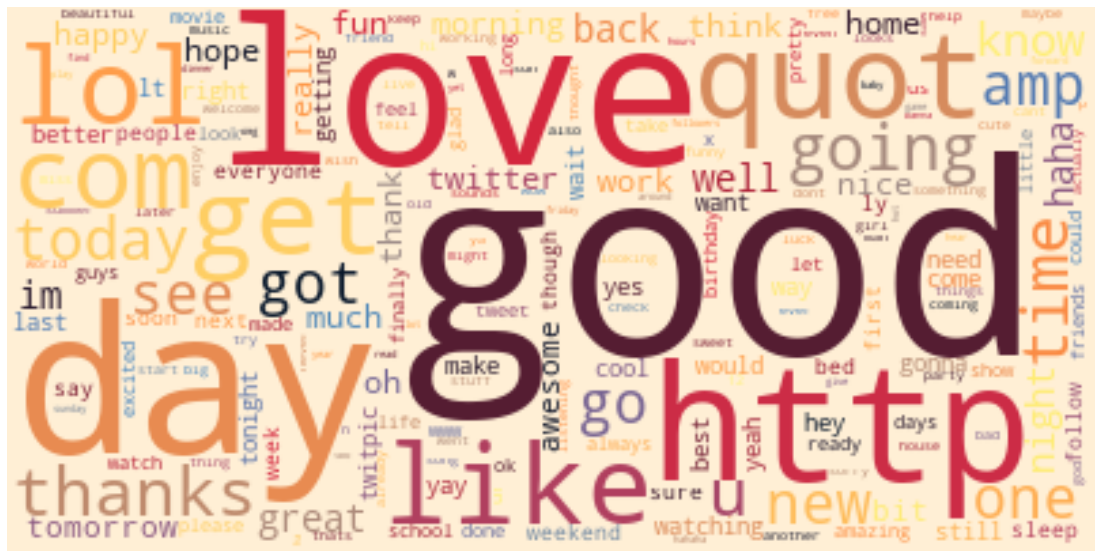

In [11]:
#Positive tweets
hero.wordcloud(data[data['Sentiment'] == 4]['CleanTweet'])

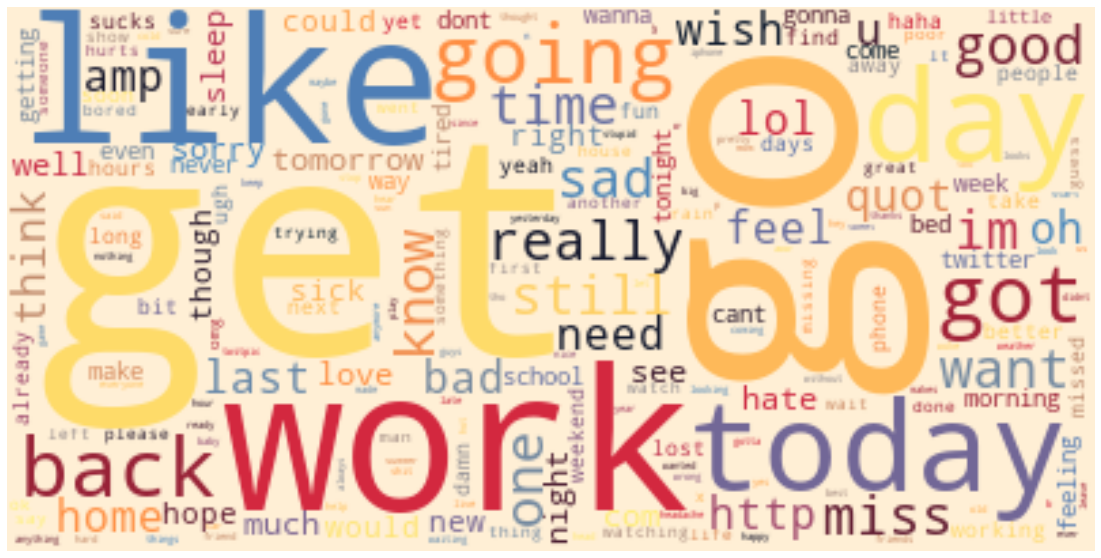

In [10]:
#Negative tweets
hero.wordcloud(data[data['Sentiment'] == 0]['CleanTweet'])

**Extracting top words for TF-IDF representation**

In [29]:
top_pos_words = hero.top_words(data[data['Sentiment'] == 4]['CleanTweet'])
top_neg_words = hero.top_words(data[data['Sentiment'] == 0]['CleanTweet'])

top_pos_dic = top_pos_words.to_dict()
top_neg_dic = top_neg_words.to_dict()

In [30]:
def get_vocabs(pos_words_dic, neg_words_dic, ft):
    vocabs = []
    for word,freq in pos_words_dic.items():
        if freq > ft and word not in vocabs:
            vocabs.append(word)

    for word,freq in neg_words_dic.items():
        if freq > ft and word not in vocabs:
            vocabs.append(word)
    return vocabs

In [31]:
ft = 0
#vocabs0 = get_vocabs(top_pos_dic, top_neg_dic, ft=ft)
print( "ft:{}, vocab lenght:{}".format(ft, len(top_neg_dic)+len(top_pos_dic)))

ft = 5
vocabs5 = get_vocabs(top_pos_dic, top_neg_dic, ft=ft)
print( "ft:{}, vocab lenght:{}".format(ft, len(vocabs5)))

ft = 25
vocabs25 = get_vocabs(top_pos_dic, top_neg_dic, ft=ft)
print( "ft:{}, vocab lenght:{}".format(ft, len(vocabs25)))

ft = 50
vocabs50 = get_vocabs(top_pos_dic, top_neg_dic, ft=ft)
print( "ft:{}, vocab lenght:{}".format(ft, len(vocabs50)))

ft = 100
vocabs100 = get_vocabs(top_pos_dic, top_neg_dic, ft=ft)
print( "ft:{}, vocab lenght:{}".format(ft, len(vocabs100)))

ft:0, vocab lenght:802544
ft:5, vocab lenght:51758
ft:25, vocab lenght:15658
ft:50, vocab lenght:9896
ft:100, vocab lenght:6138


**Train test split**

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data['CleanTweet'].tolist(), 
                                                    data['Sentiment'].tolist(),
                                                    test_size=0.3, random_state=40)

print("Train size:", len(x_train))
print("Test size:", len(x_test))

Train size: 1120000
Test size: 480000


## TFIDFPR Model

TF-IDF representation with Perceptron model

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from model import ModelPipeline
from sklearn.linear_model import Perceptron

model=ModelPipeline(estimator=Perceptron(tol=1e-3, random_state=0),
                    transformer=TfidfVectorizer(vocabulary=vocabs5) )
model.fit(x_train, y_train)

In [34]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70    239943
           4       0.70      0.73      0.72    240057

    accuracy                           0.71    480000
   macro avg       0.71      0.71      0.71    480000
weighted avg       0.71      0.71      0.71    480000



## TFIDFMLP Model

TF-IDF representation with Multi-layer Perceptron model

In [36]:
from sklearn.neural_network import MLPClassifier

model=ModelPipeline(estimator=MLPClassifier(hidden_layer_sizes=(100,100),
                                            batch_size=512, 
                                            max_iter=20, 
                                            verbose=True),
                     transformer=TfidfVectorizer(vocabulary=vocabs5)
                     )

model.fit(x_train, y_train)

Iteration 1, loss = 0.47479307
Iteration 2, loss = 0.43309434
Iteration 3, loss = 0.39742580
Iteration 4, loss = 0.34445918
Iteration 5, loss = 0.28244586
Iteration 6, loss = 0.22540753
Iteration 7, loss = 0.18304460
Iteration 8, loss = 0.15561069
Iteration 9, loss = 0.13738606
Iteration 10, loss = 0.12480291
Iteration 11, loss = 0.11592779
Iteration 12, loss = 0.10829834
Iteration 13, loss = 0.10270699
Iteration 14, loss = 0.09807194
Iteration 15, loss = 0.09442297
Iteration 16, loss = 0.09057028
Iteration 17, loss = 0.08833819
Iteration 18, loss = 0.08580354
Iteration 19, loss = 0.08367556
Iteration 20, loss = 0.08145026


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



In [37]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75    239943
           4       0.75      0.74      0.75    240057

    accuracy                           0.75    480000
   macro avg       0.75      0.75      0.75    480000
weighted avg       0.75      0.75      0.75    480000

